In [17]:
from typing import Union, Dict, Set, List, TypedDict, Annotated
import pandas as pd
from langchain_core.tools import tool
import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volume import volume_weighted_average_price
import datetime as dt

@tool
def get_stock_prices(ticker: str) -> Union[Dict, str]:
    """Fetches historical stock price data and technical indicator for a given ticker."""
    try:
        data = yf.download(
            ticker,
            start=dt.datetime.now() - dt.timedelta(weeks=24*3),
            end=dt.datetime.now(),
            interval='1wk'
        )
        df= data.copy()
        data.reset_index(inplace=True)
        data.Date = data.Date.astype(str)
        
        indicators = {}
        
        rsi_series = RSIIndicator(df['Close'], window=14).rsi().iloc[-12:]
        indicators["RSI"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in rsi_series.dropna().to_dict().items()}
        
        sto_series = StochasticOscillator(
            df['High'], df['Low'], df['Close'], window=14).stoch().iloc[-12:]
        indicators["Stochastic_Oscillator"] = {
                    date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in sto_series.dropna().to_dict().items()}

        macd = MACD(df['Close'])
        macd_series = macd.macd().iloc[-12:]
        indicators["MACD"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in macd_series.to_dict().items()}
        
        macd_signal_series = macd.macd_signal().iloc[-12:]
        indicators["MACD_Signal"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in macd_signal_series.to_dict().items()}
        
        vwap_series = volume_weighted_average_price(
            high=df['High'], low=df['Low'], close=df['Close'], 
            volume=df['Volume'],
        ).iloc[-12:]
        indicators["vwap"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in vwap_series.to_dict().items()}
        
        return {'stock_price': data.to_dict(orient='records'),
                'indicators': indicators}

    except Exception as e:
        return f"Error fetching price data: {str(e)}"


In [3]:
@tool
def get_financial_metrics(ticker: str) -> Union[Dict, str]:
    """Fetches key financial ratios for a given ticker."""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'pe_ratio': info.get('forwardPE'),
            'price_to_book': info.get('priceToBook'),
            'debt_to_equity': info.get('debtToEquity'),
            'profit_margins': info.get('profitMargins')
        }
    except Exception as e:
        return f"Error fetching ratios: {str(e)}"


LangGraph

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict,Annotated
from langgraph.graph.message import add_messages



class State(TypedDict):
    messages: Annotated[list, add_messages]
    stock: str
    
graph_builder = StateGraph(State)

In [18]:
import dotenv
dotenv.load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

tools = [get_stock_prices, get_financial_metrics]
llm_with_tool = llm.bind_tools(tools)

In [12]:
FUNDAMENTAL_ANALYST_PROMPT = """
You are a fundamental analyst specializing in evaluating company (whose symbol is {company}) performance based on stock prices, technical indicators, and financial metrics. Your task is to provide a comprehensive summary of the fundamental analysis for a given stock.

You have access to the following tools:
1. **get_stock_prices**: Retrieves the latest stock price, historical price data and technical Indicators like RSI, MACD, Drawdown and VWAP.
2. **get_financial_metrics**: Retrieves key financial metrics, such as revenue, earnings per share (EPS), price-to-earnings ratio (P/E), and debt-to-equity ratio.

### Your Task:
1. **Input Stock Symbol**: Use the provided stock symbol to query the tools and gather the relevant information.
2. **Analyze Data**: Evaluate the results from the tools and identify potential resistance, key trends, strengths, or concerns.
3. **Provide Summary**: Write a concise, well-structured summary that highlights:
    - Recent stock price movements, trends and potential resistance.
    - Key insights from technical indicators (e.g., whether the stock is overbought or oversold).
    - Financial health and performance based on financial metrics.

### Constraints:
- Use only the data provided by the tools.
- Avoid speculative language; focus on observable data and trends.
- If any tool fails to provide data, clearly state that in your summary.

### Output Format:
Respond in the following format:
"stock": "<Stock Symbol>",
"price_analysis": "<Detailed analysis of stock price trends>",
"technical_analysis": "<Detailed time series Analysis from ALL technical indicators>",
"financial_analysis": "<Detailed analysis from financial metrics>",
"final Summary": "<Full Conclusion based on the above analyses>"
"Asked Question Answer": "<Answer based on the details and analysis above>"

Ensure that your response is objective, concise, and actionable."""



In [ ]:
from langchain_core.messages import SystemMessage


def fundamental_analyst(state: State):
    messages = [
        SystemMessage(content=FUNDAMENTAL_ANALYST_PROMPT.format(company=state['stock'])),
    ]  + state['messages']
    return {
        'messages': llm_with_tool.invoke(messages)
    }


In [21]:

def tools_condition(state):
	# Example: always call all tools, or implement logic based on state/messages
 
	return [tool.name for tool in tools]

# Define a node function that can be called by the graph
def tools_node(state):
	# You can implement logic to call tools here if needed
	return state

In [22]:

graph_builder.add_node('fundamental_analyst', fundamental_analyst)
graph_builder.add_edge(START, 'fundamental_analyst')

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `fundamental_analyst` already present.

In [23]:
from langgraph.graph import StateGraph, END


graph_builder.add_node("tools", tools_node)

graph_builder.add_conditional_edges('fundamental_analyst', tools_condition)
graph_builder.add_edge('tools', 'fundamental_analyst')

graph = graph_builder.compile()

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `tools` already present.

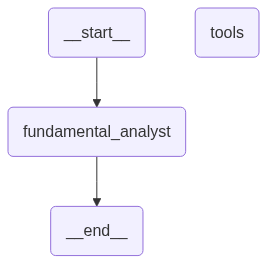

In [25]:
graph

In [24]:
events = graph.stream({'messages':[('user', 'Should I buy this stock?')],
 'stock': 'TSLA'}, stream_mode='values')
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Should I buy this stock?
================================== Ai Message ==================================
Tool Calls:
  get_stock_prices (call_pZpd4iBxzHYNkSY4Ki1ATRs2)
 Call ID: call_pZpd4iBxzHYNkSY4Ki1ATRs2
  Args:
    ticker: TSLA
  get_financial_metrics (call_1ckFkCiRpOIyCRbOro6zMgUz)
 Call ID: call_1ckFkCiRpOIyCRbOro6zMgUz
  Args:
    ticker: TSLA
